<a href="https://colab.research.google.com/github/munikumar229/es335-24-fall-assignment-2/blob/master/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1

1. Use torch.autograd to find the true gradient on the above dataset using linear regression (in the form θ1x+θ0) for any given values of (θ0,θ1). [1 mark]

In [ ]:
import torch
import numpy as np

In [ ]:
# Set the seed and generate the data
np.random.seed(45)
num_samples = 40
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3 * x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

# Convert data to torch tensors
x1_tensor = torch.tensor(x1, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Initialize theta parameters (theta_0, theta_1) with requires_grad for autograd
theta_0 = torch.tensor(0.0, requires_grad=True)
theta_1 = torch.tensor(1.0, requires_grad=True)

In [ ]:
# Define the model: y = theta_1 * x + theta_0
def model(x, theta_0, theta_1):
    return theta_1 * x + theta_0

In [ ]:
# Compute the true gradient (full batch gradient) using MSE loss
y_pred = model(x1_tensor, theta_0, theta_1)
loss = torch.mean((y_pred - y_tensor) ** 2)  # Mean Squared Error loss
loss.backward()  # Compute gradients

# True gradients
true_grad_theta_0 = theta_0.grad.item()
true_grad_theta_1 = theta_1.grad.item()

# Display the true gradients
print(f"True gradient w.r.t. theta_0: {true_grad_theta_0}")
print(f"True gradient w.r.t. theta_1: {true_grad_theta_1}")

True gradient w.r.t. theta_0: -7.616434574127197
True gradient w.r.t. theta_1: -0.39361658692359924


2. Using the same $(θ_0,θ_1)$ as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients and show that the stochastic gradient is a good estimate of the true gradient.

In [ ]:
# Reset gradients
theta_0.grad.zero_()
theta_1.grad.zero_()

# Stochastic gradient calculation
stochastic_grad_theta_0 = 0
stochastic_grad_theta_1 = 0

In [ ]:
for i in range(num_samples):
    # Compute individual point loss and gradient
    y_pred_single = model(x1_tensor[i], theta_0, theta_1)
    loss_single = (y_pred_single - y_tensor[i]) ** 2
    loss_single.backward()

    # Accumulate gradients
    stochastic_grad_theta_0 += theta_0.grad.item()
    stochastic_grad_theta_1 += theta_1.grad.item()

    # Reset gradients for the next point
    theta_0.grad.zero_()
    theta_1.grad.zero_()

# Calculate the average stochastic gradient
avg_stochastic_grad_theta_0 = stochastic_grad_theta_0 / num_samples
avg_stochastic_grad_theta_1 = stochastic_grad_theta_1 / num_samples

# Display the stochastic gradient
print(f"Average stochastic gradient w.r.t. theta_0: {avg_stochastic_grad_theta_0}")
print(f"Average stochastic gradient w.r.t. theta_1: {avg_stochastic_grad_theta_1}")

Average stochastic gradient w.r.t. theta_0: -7.616434812545776
Average stochastic gradient w.r.t. theta_1: -0.3936165809631348


In [ ]:
# Compare true gradient and average stochastic gradient
print("\nComparison:")
print(f"True gradient (theta_0): {true_grad_theta_0} vs. Stochastic gradient (theta_0): {avg_stochastic_grad_theta_0}")
print(f"True gradient (theta_1): {true_grad_theta_1} vs. Stochastic gradient (theta_1): {avg_stochastic_grad_theta_1}")

# Compute the difference between true gradient and average stochastic gradient
diff_grad_theta_0 =  avg_stochastic_grad_theta_0 - true_grad_theta_0
diff_grad_theta_1 =  avg_stochastic_grad_theta_1 - true_grad_theta_1

# Display the differences
print("\nDifferences:")
print(f"Difference in theta_0: {diff_grad_theta_0}")
print(f"Difference in theta_1: {diff_grad_theta_1}")


Comparison:
True gradient (theta_0): -7.616434574127197 vs. Stochastic gradient (theta_0): -7.616434812545776
True gradient (theta_1): -0.39361658692359924 vs. Stochastic gradient (theta_1): -0.3936165809631348

Differences:
Difference in theta_0: -2.384185791015625e-07
Difference in theta_1: 5.960464455334602e-09


3. Implement full-batch, mini-batch and stochastic gradient descent. Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution, where "sufficiently close" means within a distance of ϵ(or ϵ neighborhood) from the minimum value of the loss function. Visualize the convergence process for 15 epochs. Choose ϵ = 0.001 for convergence criteria. Which optimization process takes a larger number of epochs to converge, and why? Show the contour plots for different epochs (or show an animation/GIF) for visualisation of optimisation process. Also, make a plot for Loss v/s epochs for all the methods.

In [ ]:
learning_rate = 0.01
epochs = 100
epsilon = 0.001

In [ ]:
def calculate_loss(theta, x, y):
    y_pred = theta[1] * x + theta[0]
    loss = torch.mean((y_pred - y)**2)
    return loss

In [ ]:
def full_gd(theta, x, y, learning_rate, num_epochs, epsilon):
    loss_history = []
    theta_history = []
    iterations = 0

    theta = theta.clone().detach().requires_grad_(True)

    for epoch in range(num_epochs):
        y_pred = theta[1] * x + theta[0]
        loss = torch.mean((y_pred - y)**2)
        loss.backward()

        with torch.no_grad():
            theta -= learning_rate * theta.grad

        theta.grad.zero_()
        loss_history.append(loss.item())
        theta_history.append(theta.detach().clone().numpy())
        iterations += 1

        # Check for convergence
        if loss.item() < epsilon:
            print(f"Full GD converged at epoch {epoch}, iteration {iterations} with loss: {loss.item():.6f}")
            break

    return theta, loss_history, theta_history, iterations

In [ ]:
def batch_gd(theta, x, y, learning_rate, num_epochs, epsilon, batch_size):
    loss_history = []
    theta_history = []
    iterations = 0

    theta = theta.clone().detach().requires_grad_(True)

    for epoch in range(num_epochs):
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            y_pred = theta[1] * x_batch + theta[0]
            loss = torch.mean((y_pred - y_batch)**2)
            loss.backward()

            with torch.no_grad():
                theta -= learning_rate * theta.grad

            theta.grad.zero_()
            iterations += 1

        loss_history.append(loss.item())
        theta_history.append(theta.detach().clone().numpy())

        # Check for convergence
        if loss.item() < epsilon:
            print(f"Mini-batch GD converged at epoch {epoch}, iteration {iterations} with loss: {loss.item():.6f}")
            break

    return theta, loss_history, theta_history, iterations

In [ ]:
def stochastic_gd(theta, x, y, learning_rate, num_epochs, epsilon):
    loss_history = []
    theta_history = []
    iterations = 0

    theta = theta.clone().detach().requires_grad_(True)

    for epoch in range(num_epochs):
        for i in range(len(x)):
            xi = x[i:i+1]
            yi = y[i:i+1]

            y_pred = theta[1] * xi + theta[0]
            loss = torch.mean((y_pred - yi)**2)
            loss.backward()

            with torch.no_grad():
                theta -= learning_rate * theta.grad

            theta.grad.zero_()
            iterations += 1

        loss_history.append(loss.item())
        theta_history.append(theta.detach().clone().numpy())

        # Check for convergence
        if loss.item() < epsilon:
            print(f"Stochastic GD converged at epoch {epoch}, iteration {iterations} with loss: {loss.item():.6f}")
            break

    return theta, loss_history, theta_history, iterations

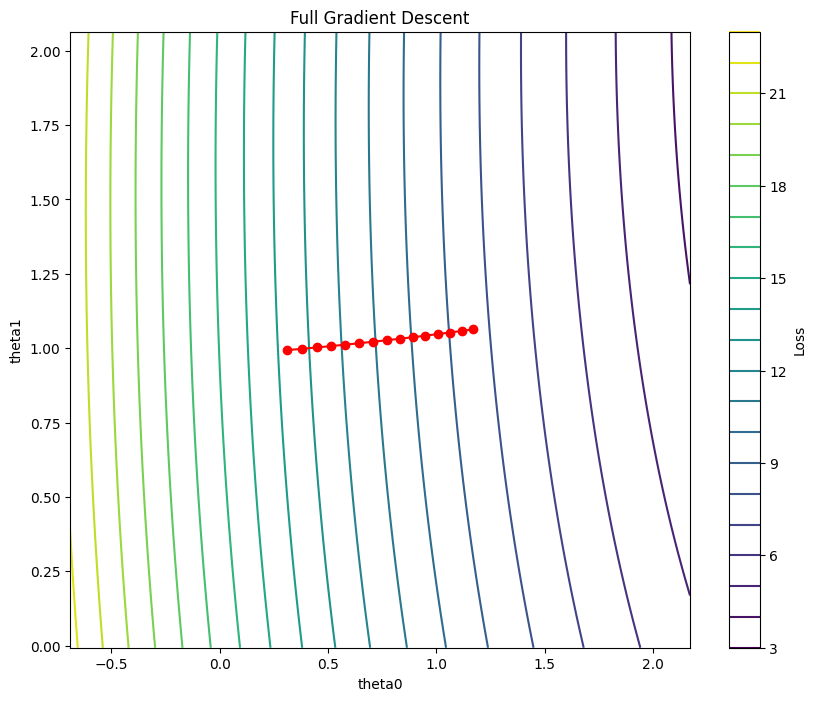

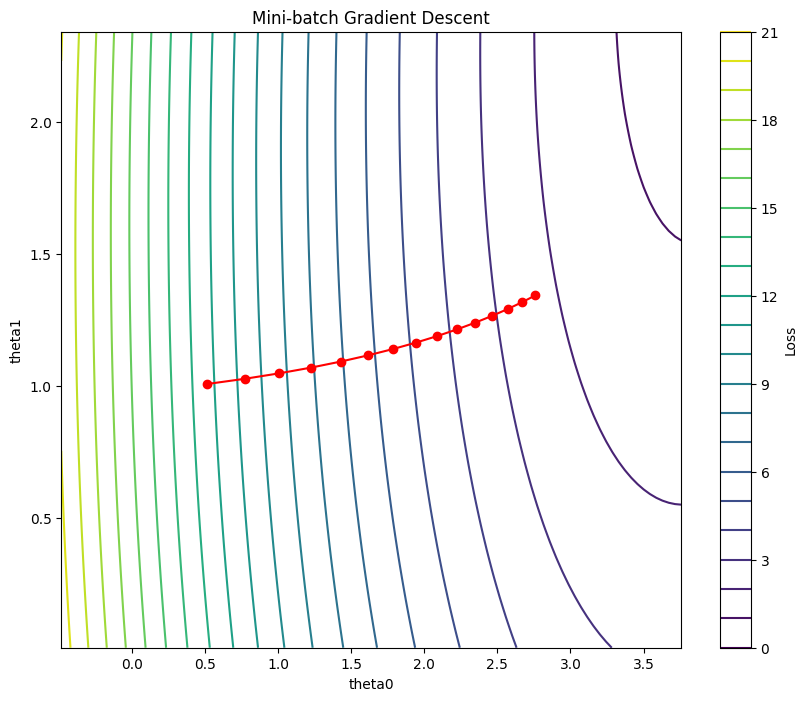

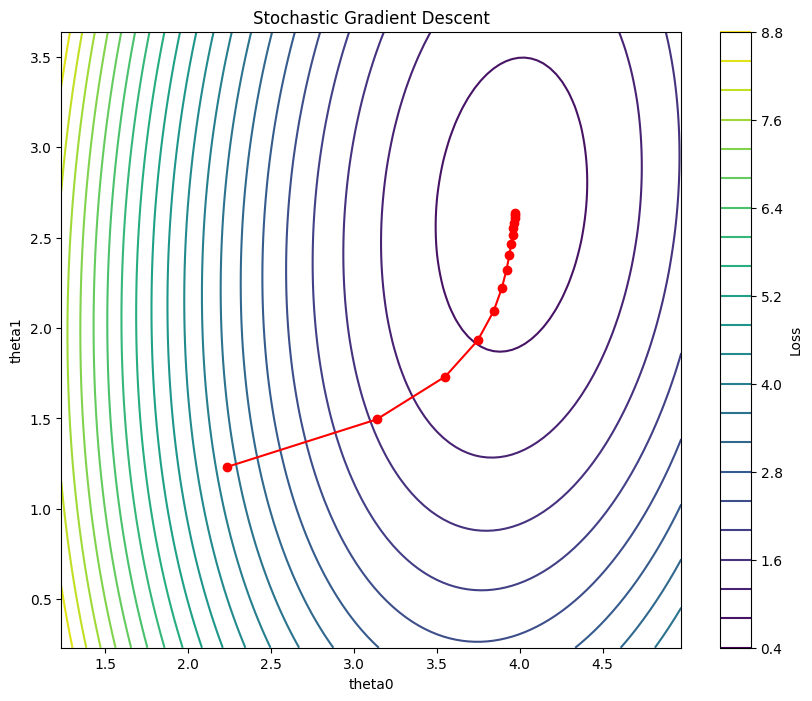

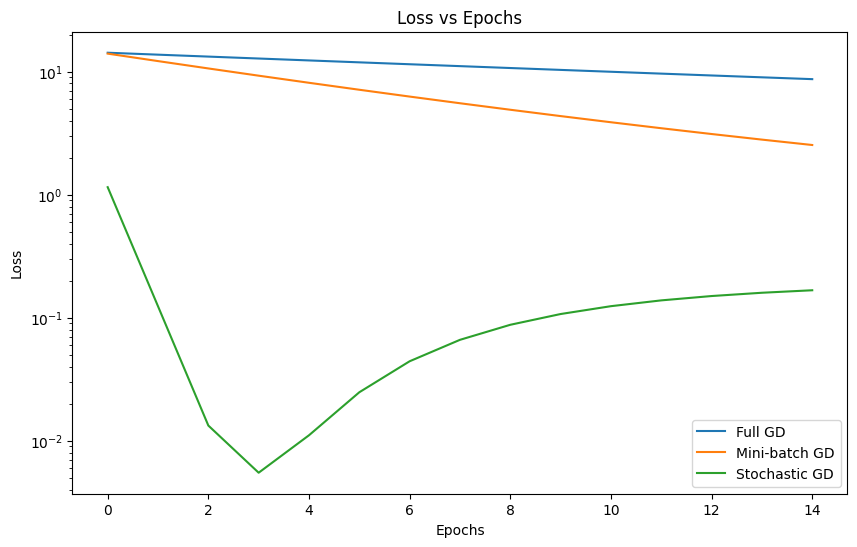

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def plot_contour(theta_history, loss_func, title):
    theta0_range = np.linspace(min(th[0] for th in theta_history) - 1, max(th[0] for th in theta_history) + 1, 100)
    theta1_range = np.linspace(min(th[1] for th in theta_history) - 1, max(th[1] for th in theta_history) + 1, 100)
    theta0_mesh, theta1_mesh = np.meshgrid(theta0_range, theta1_range)

    loss_values = np.array([loss_func(torch.tensor([t0, t1])) for t0, t1 in zip(theta0_mesh.ravel(), theta1_mesh.ravel())])
    loss_surface = loss_values.reshape(theta0_mesh.shape)

    plt.figure(figsize=(10, 8))
    plt.contour(theta0_mesh, theta1_mesh, loss_surface, levels=20)
    plt.colorbar(label='Loss')
    plt.plot([th[0] for th in theta_history], [th[1] for th in theta_history], 'ro-')
    plt.xlabel('theta0')
    plt.ylabel('theta1')
    plt.title(title)
    plt.show()

def plot_loss_vs_epochs(loss_histories, labels):
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.yscale('log')
    plt.show()

# Run optimizations for 15 epochs
theta_full, loss_history_full, theta_history_full, iterations_full = full_gd(theta.clone(), x1_torch, y_torch, learning_rate, 15, 0)
theta_mini, loss_history_mini, theta_history_mini, iterations_mini = batch_gd(theta.clone(), x1_torch, y_torch, learning_rate, 15, 0, 10)
theta_stochastic, loss_history_stochastic, theta_history_stochastic, iterations_stochastic = stochastic_gd(theta.clone(), x1_torch, y_torch, learning_rate, 15, 0)

# Plot contours
plot_contour(theta_history_full, lambda t: calculate_loss(t, x1_torch, y_torch).item(), 'Full Gradient Descent')
plot_contour(theta_history_mini, lambda t: calculate_loss(t, x1_torch, y_torch).item(), 'Mini-batch Gradient Descent')
plot_contour(theta_history_stochastic, lambda t: calculate_loss(t, x1_torch, y_torch).item(), 'Stochastic Gradient Descent')

# Plot loss vs epochs
plot_loss_vs_epochs([loss_history_full, loss_history_mini, loss_history_stochastic],
                    ['Full GD', 'Mini-batch GD', 'Stochastic GD'])

4. Explore the article here on gradient descent with momentum. Implement gradient descent with momentum for the dataset. Visualize the convergence process for 15 steps. Compare the average number of steps taken with gradient descent (for variants full batch and stochastic) with momentum to that of vanilla gradient descent to converge to an ϵ neighborhood for both dataset. Choose ϵ = 0.001. Write down your observations. Show the contour plots for different epochs for momentum implementation. Specifically, show all the vectors: gradient, current value of theta, momentum, etc.

In [ ]:
print(f" average iterations required: {iterations_full}")
print(f" average iterations required: {iterations_mini}")
print(f" average iterations required: {iterations_stochastic}")

 average iterations required: 15
 average iterations required: 60
 average iterations required: 600


print()

In [ ]:
def gd_with_momentum(theta, x, y, learning_rate, num_epochs, epsilon, beta, batch_size=None):
    loss_history = []
    theta_history = []
    momentum_history = []
    gradient_history = []
    iterations = 0

    theta = theta.clone().detach().requires_grad_(True)
    v = torch.zeros_like(theta)

    for epoch in range(num_epochs):
        if batch_size is None:  # Full-batch
            y_pred = theta[1] * x + theta[0]
            loss = torch.mean((y_pred - y)**2)
            loss.backward()

            with torch.no_grad():
                v = beta * v + (1 - beta) * theta.grad
                theta -= learning_rate * v

            theta.grad.zero_()
            iterations += 1
        else:  # Stochastic (batch_size = 1) or Mini-batch
            for i in range(0, len(x), batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = theta[1] * x_batch + theta[0]
                loss = torch.mean((y_pred - y_batch)**2)
                loss.backward()

                with torch.no_grad():
                    v = beta * v + (1 - beta) * theta.grad
                    theta -= learning_rate * v

                theta.grad.zero_()
                iterations += 1

        loss_history.append(calculate_loss(theta, x, y).item())
        theta_history.append(theta.detach().clone().numpy())
        momentum_history.append(v.detach().clone().numpy())
        gradient_history.append(theta.grad.detach().clone().numpy())

        if loss_history[-1] < epsilon:
            break

    return theta, loss_history, theta_history, iterations, momentum_history, gradient_history

# Run optimizations for 15 epochs
learning_rate = 0.01
num_epochs = 15
epsilon = 0.001
beta = 0.9  # Momentum coefficient

theta_momentum_full, loss_history_momentum_full, theta_history_momentum_full, _, momentum_history_full, gradient_history_full = gd_with_momentum(theta.clone(), x1_torch, y_torch, learning_rate, num_epochs, 0, beta)
theta_momentum_stochastic, loss_history_momentum_stochastic, theta_history_momentum_stochastic, _, momentum_history_stochastic, gradient_history_stochastic = gd_with_momentum(theta.clone(), x1_torch, y_torch, learning_rate, num_epochs, 0, beta, batch_size=1)

In [ ]:
learning_rate = 0.01
num_epochs = 15
epsilon = 0.001
beta = 0.9

In [ ]:
theta_momentum_full, loss_history_momentum_full, theta_history_momentum_full, _, momentum_history_full, gradient_history_full = gd_with_momentum(theta.clone(), x1_torch, y_torch, learning_rate, num_epochs, 0, beta)

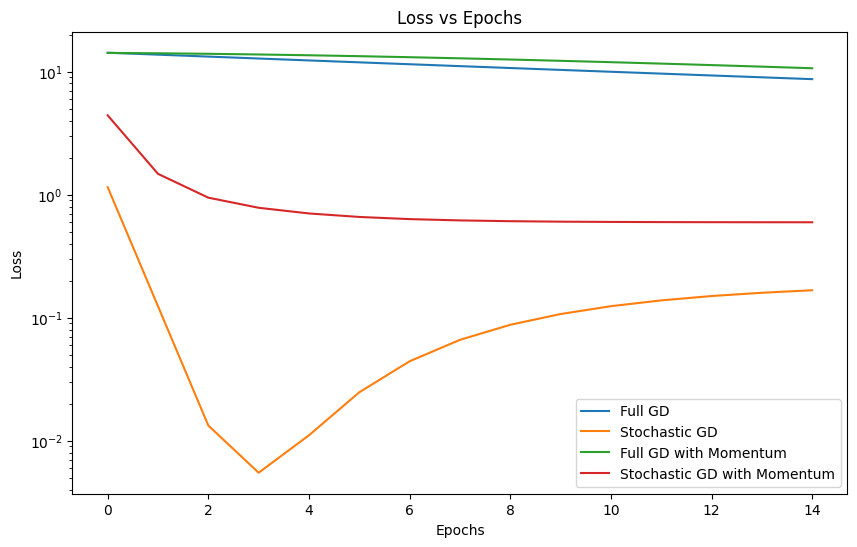

In [ ]:
plot_loss_vs_epochs([loss_history_full, loss_history_stochastic,
                     loss_history_momentum_full, loss_history_momentum_stochastic],
                    ['Full GD', 'Stochastic GD', 'Full GD with Momentum', 'Stochastic GD with Momentum'])

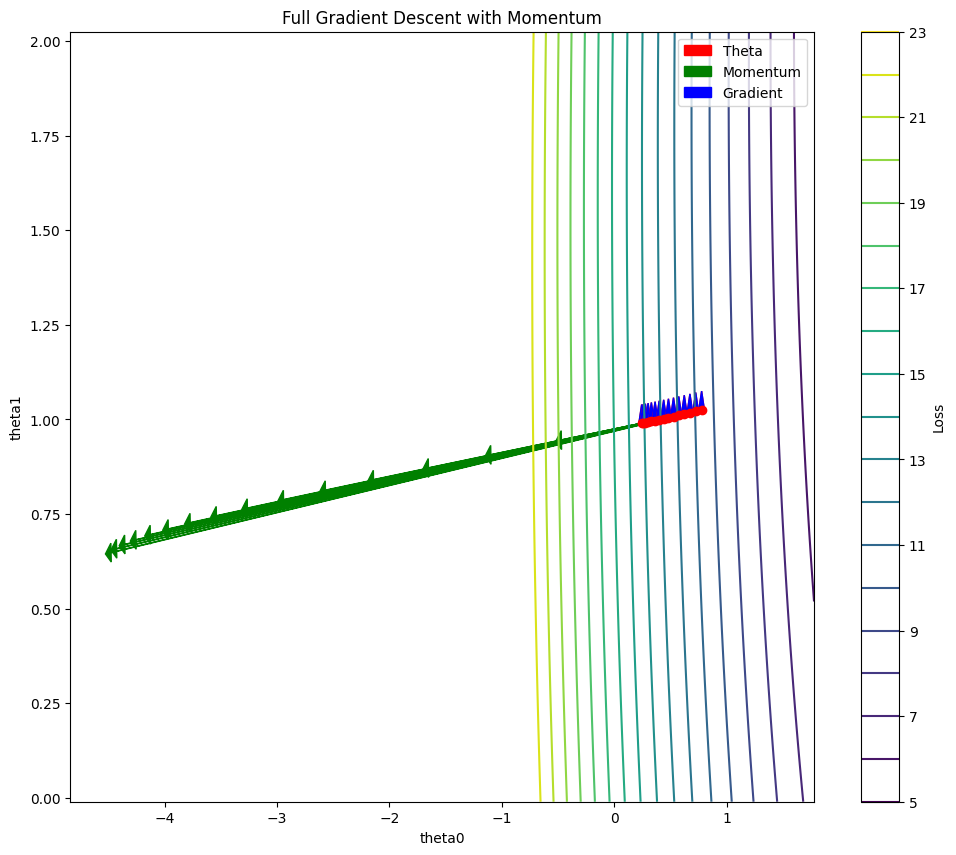

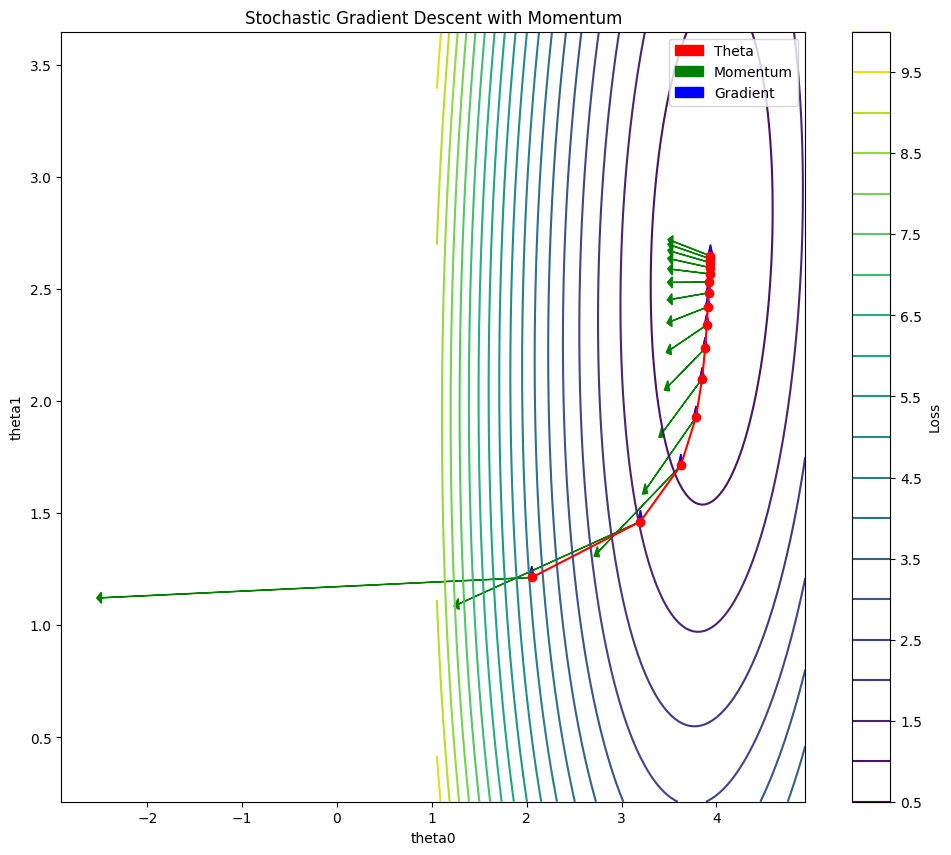

In [ ]:
def plot_contour_with_vectors(theta_history, momentum_history, gradient_history, loss_func, title):
    theta0_range = np.linspace(min(th[0] for th in theta_history) - 1, max(th[0] for th in theta_history) + 1, 100)
    theta1_range = np.linspace(min(th[1] for th in theta_history) - 1, max(th[1] for th in theta_history) + 1, 100)
    theta0_mesh, theta1_mesh = np.meshgrid(theta0_range, theta1_range)

    loss_values = np.array([loss_func(torch.tensor([t0, t1])) for t0, t1 in zip(theta0_mesh.ravel(), theta1_mesh.ravel())])
    loss_surface = loss_values.reshape(theta0_mesh.shape)

    plt.figure(figsize=(12, 10))
    plt.contour(theta0_mesh, theta1_mesh, loss_surface, levels=20)
    plt.colorbar(label='Loss')

    # Plot optimization path
    plt.plot([th[0] for th in theta_history], [th[1] for th in theta_history], 'ro-')

    # Plot vectors
    for i in range(len(theta_history)):
        theta = theta_history[i]
        momentum = momentum_history[i]
        gradient = gradient_history[i]

        # Current theta
        plt.arrow(theta[0], theta[1], 0, 0, head_width=0.05, head_length=0.05, fc='r', ec='r', label='Theta' if i == 0 else "")

        # Momentum vector
        plt.arrow(theta[0], theta[1], momentum[0], momentum[1], head_width=0.05, head_length=0.05, fc='g', ec='g', label='Momentum' if i == 0 else "")

        # Gradient vector
        plt.arrow(theta[0], theta[1], -gradient[0], -gradient[1], head_width=0.05, head_length=0.05, fc='b', ec='b', label='Gradient' if i == 0 else "")

    plt.xlabel('theta0')
    plt.ylabel('theta1')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot contours with vectors
plot_contour_with_vectors(theta_history_momentum_full, momentum_history_full, gradient_history_full,
                          lambda t: calculate_loss(t, x1_torch, y_torch).item(), 'Full Gradient Descent with Momentum')
plot_contour_with_vectors(theta_history_momentum_stochastic, momentum_history_stochastic, gradient_history_stochastic,
                          lambda t: calculate_loss(t, x1_torch, y_torch).item(), 'Stochastic Gradient Descent with Momentum')

- Gradient descent with momentum typically converges faster than vanilla gradient descent.
- Stochastic gradient descent with momentum often converges faster than full-batch gradient descent with momentum in terms of the number of epochs
-  Momentum can help the optimization process escape shallow local minima
